### Load modules

In [1]:
# general
import os
import sys
import time
import numpy as np 
import matplotlib.pyplot as plt 
import random as rnd

# Numpyro
import numpyro
import numpyro.distributions as npdist
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)

#JAX
import jax
import flax
from flax.training import train_state  # Useful dataclass to keep train state
import optax

# PyTorch
import torch
import torch.utils.data as data

# check versions
print('Pytorch version: ',   torch.__version__)
print('Numpyro version: ', numpyro.__version__)
print('JAX version:     ',     jax.__version__)
print('Flax version:    ',    flax.__version__)
print('Optax version:   ',   optax.__version__)
from platform import python_version
print('Pythorch version:',python_version())

# import priors 
#from models.priors import *

# import functions to load data
from priorCVAE.models.data import *

# import VAE architecture
from priorCVAE.models.cvae import *

# import loss functions
from priorCVAE.models.losses import *

# Test dist_euclid
#x1 = jnp.array([1,2,3])
#dist_euclid(x1,x1)

# test kl_divergence
#x1 = jnp.array([1.1,2,3])
#kl = kl_divergence(x1, x1)
#kl

Pytorch version:  2.0.0
Numpyro version:  0.12.1
JAX version:      0.4.12
Flax version:     0.6.10
Optax version:    0.1.5
Pythorch version: 3.9.16


In [23]:
# run script to test architecture
# %run test_architecture.py

Exception: File `'test_architecture.py'` not found.

### Setup arguments

In [2]:
args = {"seed": 0,
        
        # data
        "num_samples": 10000,
        
        # architecture
        "conditional": False,   # CVAE if True, VAE otherwise
        "input_dim" : 50,
        "hidden_dim": 40,
        "latent_dim": 30,
        
        # VAE setup    
        "batch_size": 100,
       }

### Generate data


In [3]:
train_set = Dataset_GP1d(n_dataPoints=args["input_dim"], n_samples=args["num_samples"], seed=42)  
val_set   = Dataset_GP1d(n_dataPoints=args["input_dim"], n_samples=args["num_samples"], seed=43)  
test_set  = Dataset_GP1d(n_dataPoints=args["input_dim"], n_samples=args["num_samples"], seed=44)  

train_loader, val_loader, test_loader = create_data_loaders(train_set, val_set, test_set,
                                                            train=[True, False, False],
                                                            batch_size=args["batch_size"])
train_loader_iter = iter(train_loader)
val_loader_iter   = iter(val_loader)
test_loader_iter  = iter(test_loader)

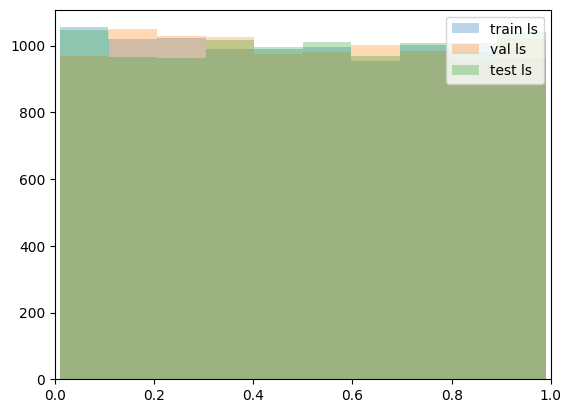

In [4]:
# check: what lengthscales are we generating? 

ls_train_set = train_set.ls
ls_val_set   = val_set.ls
ls_test_set  = test_set.ls

plt.hist(ls_train_set, alpha = 0.3, label = 'train ls') 
plt.hist(ls_val_set,   alpha = 0.3, label = 'val ls') 
plt.hist(ls_test_set,  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()

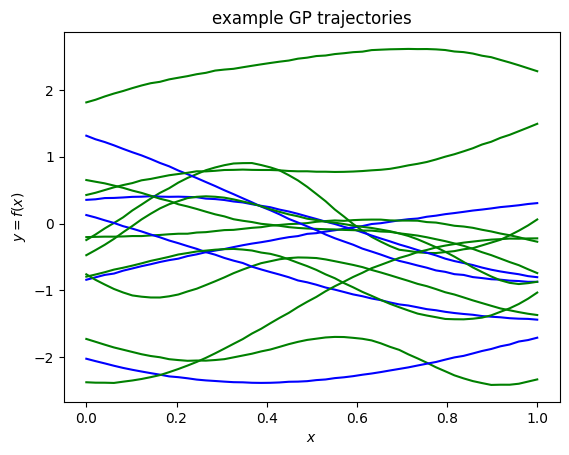

In [5]:
# check: what trajectories are we generating?

fig, ax = plt.subplots()
for i in range(15):
    if train_set.ls[i] <= 0.2:
        col = 'orange'
    elif train_set.ls[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(train_set.x[i], train_set.y[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('example GP trajectories')

plt.show()

### VAE Model

In [6]:
out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
conditional = args["conditional"]
batch_size  = args["batch_size"]
num_samples = args["num_samples"]

### Training loop

In [8]:
# define model
model = VAE(hidden_dim, latent_dim, out_dim, conditional)

# initialise parameters
key = jax.random.PRNGKey(0) 
batch = next(test_loader_iter) # batch[0] - x, batch[1] - y, batch[2] - c
_, y, _ = batch
params = model.init(key, y)['params']

# optimizer
optimizer = optax.adam(learning_rate=0.001)

# store training state
state = train_state.TrainState.create(apply_fn=model, params=params, tx=optimizer)

In [10]:
# check architecture
#print(model.tabulate(key, train_set.y,
#      console_kwargs={'force_terminal': False, 'force_jupyter': True}))

In [14]:
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        _, y, _ = batch 
        y_hat, z_mu, z_sd = model.apply({'params': params}, y) 
        rcl_loss = rcl(y_hat, y).mean()
        kld_loss = kl_divergence(z_mu, z_sd).mean()
        loss = rcl_loss + kld_loss
        return loss
    
    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads), loss_fn(state.params)

In [15]:
#rng = jax.random.PRNGKey(45) 

num_epochs = 15
#steps_per_epoch = num_samples // batch_size -
steps_per_epoch = 3

_loss = []

for epoch in range(num_epochs):
    for _ in range(steps_per_epoch):
      batch = next(train_loader_iter)
      state, loss = train_step(state, batch)
      _loss.append(loss)

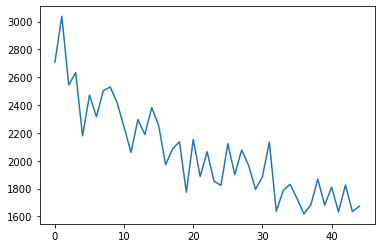

In [17]:
len(_loss)

plt.plot(range(len(_loss)), _loss, label = 'Training loss')

In [18]:
#train_step(state, batch)